### 1.
Importing data and splitting into test, validation and training data. (Only run one time)

In [34]:
import os
import numpy as np
import pandas as pd
import torch

def fit_minmax(X):
    """Fit per-feature min-max on X (2D). Returns (mins, ranges) with safe ranges."""
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = maxs - mins
    rng_safe = np.where(rng > 0, rng, 1.0)  # avoid division by zero (constant features)
    return mins.astype(DTYPE), rng_safe.astype(DTYPE)

def transform_minmax(X, mins, rng_safe):
    return ((X - mins) / rng_safe).astype(DTYPE)

def inverse_minmax(X_scaled, mins, rng_safe):
    return (X_scaled * rng_safe + mins).astype(DTYPE)

def split_dataframe_rows(df, train_frac, val_frac, test_frac, seed=42):
    """Split the *rows* of the original df into train/val/test by fraction."""
    assert abs((train_frac + val_frac + test_frac) - 1.0) < 1e-8, "Fractions must sum to 1."
    rng = np.random.default_rng(seed)
    idx = df.index.to_numpy()
    rng.shuffle(idx)

    n = len(idx)
    n_train = int(round(train_frac * n))
    n_val = int(round(val_frac * n))
    n_test = n - n_train - n_val

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train + n_val]
    test_idx  = idx[n_train + n_val:]

    return df.loc[train_idx], df.loc[val_idx], df.loc[test_idx]


def expand_split(df_split):
    """
    Expand a split of the original df into (X, Y) arrays by iterating each row,
    parsing vector fields, masking NaNs per-row, and stacking all samples.
    """
    inputs, outputs = [], []

    for _, row in df_split.iterrows():
        # ---- scalar inputs (with the same preprocessing as in your pipeline) ----
        dV_ges   = float(row["dV_ges"]) / 3.6 * 1e-6
        eps_0    = float(row["eps_0"])
        phi_0    = float(row["phi_0"])
        h_dis_0  = float(row["h_dis_0"])
        h_c_0    = float(row["h_c_0"])
        rho_c    = float(row["rho_c"])
        rho_d    = float(row["rho_d"])
        eta_c    = float(row["eta_c"])
        eta_d    = float(row["etc_d"])
        sigma    = float(row["sigma"])
        T        = float(row["T"])
        r_s_star = float(row["r_S_star"])
        h_p_star = float(row["h_p_star"])
        D_A      = float(row["D_A"])
        L_A      = float(row["L_A"])

        # ---- vector fields (convert units like before) ----
        DPZ_pos    = np.fromstring(str(row['DPZ_pos_ivgu']).strip("[]"), sep=",") / 100.0     # m
        DPZ_height = np.fromstring(str(row['DPZ_height_ivgu']).strip("[]"), sep=",") / 1000.0 # m
        DPZ_bot    = np.fromstring(str(row['DPZ_bot_ivgu']).strip("[]"), sep=",") / 1000.0   # m

        # ---- per-row NaN mask to keep only valid aligned entries ----
        mask = ~(np.isnan(DPZ_pos) | np.isnan(DPZ_height) | np.isnan(DPZ_bot))
        if not np.any(mask):
            continue  # skip row if nothing valid

        DPZ_pos_v    = DPZ_pos[mask]
        DPZ_height_v = DPZ_height[mask]
        DPZ_bot_v    = DPZ_bot[mask]

        # ---- expand: one sample per DPZ position ----
        const_feats = [dV_ges, eps_0, phi_0, h_dis_0, h_c_0, rho_c, rho_d,
                       eta_c, eta_d, sigma, T, r_s_star, h_p_star, D_A, L_A]
        for i in range(len(DPZ_pos_v)):
            x_vec = const_feats + [DPZ_pos_v[i]]
            y_vec = [DPZ_height_v[i]+DPZ_bot_v[i], DPZ_bot_v[i]]
            inputs.append(x_vec)
            outputs.append(y_vec)

    X = np.array(inputs, dtype=DTYPE)
    Y = np.array(outputs, dtype=DTYPE)
    return X, Y

In [35]:
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15
SEED = 42
DTYPE = np.float32
CSV_PATH = os.path.join("Input", "df_dpz.csv")

# 1) Read original CSV
df = pd.read_csv(CSV_PATH)

# 2) Split by original rows (no expansion yet)
train_df, val_df, test_df = split_dataframe_rows(df, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=SEED)
print(f"Row splits: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
test_df.to_csv("df_te.csv", index=False)

# 3) Expand each split separately (no cross-split leakage)
X_train, Y_train = expand_split(train_df)
X_val,   Y_val   = expand_split(val_df)
X_test,  Y_test  = expand_split(test_df)

print("Expanded sample counts:", f"train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
print("Feature/Target dims:", X_train.shape[1], Y_train.shape[1])

# 4) Fit Min–Max on TRAIN only; transform all splits
x_mins, x_rng = fit_minmax(X_train)
y_mins, y_rng = fit_minmax(Y_train)

X_train_n = transform_minmax(X_train, x_mins, x_rng)
X_val_n   = transform_minmax(X_val,   x_mins, x_rng)
X_test_n  = transform_minmax(X_test,  x_mins, x_rng)

Y_train_n = transform_minmax(Y_train, y_mins, y_rng)
Y_val_n   = transform_minmax(Y_val,   y_mins, y_rng)
Y_test_n  = transform_minmax(Y_test,  y_mins, y_rng)

# 5) Convert to torch tensors (ready for DataLoaders)
X_train_t = torch.from_numpy(X_train_n)
Y_train_t = torch.from_numpy(Y_train_n)
X_val_t   = torch.from_numpy(X_val_n)
Y_val_t   = torch.from_numpy(Y_val_n)
X_test_t  = torch.from_numpy(X_test_n)
Y_test_t  = torch.from_numpy(Y_test_n)

print("Torch tensors:",
      X_train_t.shape, Y_train_t.shape,
      X_val_t.shape,   Y_val_t.shape,
      X_test_t.shape,  Y_test_t.shape)

# Save normalization params for inference-time inverse-transform
np.savez(
    "minmax_params_dnn_7_(dpz).npz",
    x_mins=x_mins, x_rng=x_rng,
    y_mins=y_mins, y_rng=y_rng
)

# Save splits as torch tensors
data = {
    "X_train_t": X_train_t,
    "Y_train_t": Y_train_t,
    "X_val_t":   X_val_t,
    "Y_val_t":   Y_val_t,
    "X_test_t":  X_test_t,
    "Y_test_t":  Y_test_t,
    "X_train_n": X_train_n,
    "Y_train_n": Y_train_n,
    "X_val_n":   X_val_n,
    "Y_val_n":   Y_val_n,
    "X_test_n":  X_test_n,
    "Y_test_n":  Y_test_n,
}

# Save all in one file
torch.save(data, 'datasets_dnn_7_(dpz).pt')

Row splits: train=297, val=64, test=63
Expanded sample counts: train=7005, val=1536, test=1483
Feature/Target dims: 16 2
Torch tensors: torch.Size([7005, 16]) torch.Size([7005, 2]) torch.Size([1536, 16]) torch.Size([1536, 2]) torch.Size([1483, 16]) torch.Size([1483, 2])


### 2.
Creating the model

In [36]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import math
import matplotlib.pyplot as plt

DTYPE = np.float32
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True  # faster on GPU

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_data = torch.load("saved_models/dnn_6_(dpz)/datasets_dnn_6_(dpz).pt")

# Access tensors or arrays
X_train_t = loaded_data["X_train_t"]
X_train_n = loaded_data["X_train_n"]
Y_train_t = loaded_data["Y_train_t"]
Y_train_n = loaded_data["Y_train_n"]
X_val_t = loaded_data["X_val_t"]
X_val_n = loaded_data["X_val_n"]
Y_val_t = loaded_data["Y_val_t"]
Y_val_n = loaded_data["Y_val_n"]
X_test_t = loaded_data["X_test_t"]
X_test_n = loaded_data["X_test_n"]
Y_test_t = loaded_data["Y_test_t"]
Y_test_n = loaded_data["Y_test_n"]

loaded_data_n = np.load("saved_models/dnn_6_(dpz)/minmax_params_dnn_6_(dpz).npz")
x_mins = loaded_data_n["x_mins"]
x_rng = loaded_data_n["x_rng"]
y_mins = loaded_data_n["y_mins"]
y_rng = loaded_data_n["y_rng"]


class DNN(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, activation="silu", dropout=0.0):
        super().__init__()
        acts = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "silu": nn.SiLU,
            "tanh": nn.Tanh
        }
        if activation not in acts:
            raise ValueError(f"activation must be one of {list(acts.keys())}")
        Act = acts[activation]

        layers = []
        prev = in_dim
        for i, h in enumerate(hidden_dims):
            layers += [nn.Linear(prev, h), Act()]
            if dropout and dropout > 0:
                layers += [nn.Dropout(p=dropout)]
            prev = h
        # Linear output for regression
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

        # Weight init (He for ReLU/SiLU/GELU, Xavier for Tanh)
        for m in self.net:
            if isinstance(m, nn.Linear):
                if activation in ("relu", "silu", "gelu"):
                    nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                else:  # tanh
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        return self.net(x)
    
in_dim  = X_train_t.shape[1]
out_dim = Y_train_t.shape[1]
hidden  = [192, 384, 384, 192]
dropout = 0.05701
activation = 'gelu'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN(in_dim, hidden, out_dim, activation=activation, dropout=dropout).to(device)

C:\Users\iagr9\AppData\Local\Temp\ipykernel_26684\1720923421.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load("saved_models/dnn_6_(dpz)/datasets

### 4.
Train the model

In [37]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 64
train_ds = TensorDataset(X_train_t, Y_train_t)
val_ds   = TensorDataset(X_val_t,   Y_val_t)
test_ds  = TensorDataset(X_test_t,  Y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.MSELoss()  # targets are scaled; MSE is fine
lr = 8.7e-4
weight_decay = 1.55e-7
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=30)


Training loop

In [ ]:
EPOCHS = 300
PATIENCE = 30
steps_per_epoch = max(1, len(train_loader))
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=EPOCHS, steps_per_epoch=steps_per_epoch)
best_val = float("inf")
best_state = None
epochs_no_improve = 0
losses_history = []

for epoch in range(1, EPOCHS + 1):
    # train
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    lr = optimizer.param_groups[0]['lr']
    losses_history.append([train_loss, val_loss, lr])

    scheduler.step(val_loss)

    if val_loss < best_val - 1e-8:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch:03d} | train MSE: {train_loss:.6f} | val MSE: {val_loss:.6f} | LR: {lr:.2e}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch}. Best val MSE: {best_val:.6f}")
        break


# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

Epoch 001 | train MSE: 0.015250 | val MSE: 0.009672 | LR: 8.70e-04
Epoch 002 | train MSE: 0.008749 | val MSE: 0.008837 | LR: 8.70e-04


In [ ]:
print(f"Best val MSE: {best_val:.6f}")

Best val MSE: 0.001287


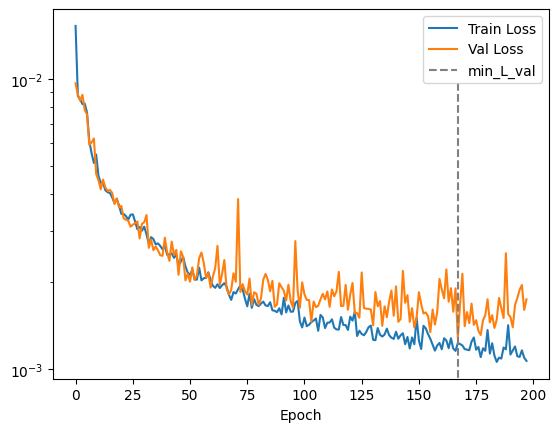

In [ ]:
import matplotlib.pyplot as plt
losses_history = np.array(losses_history)
plt.plot(losses_history[:,0], label='Train Loss')
plt.plot(losses_history[:,1], label='Val Loss')
plt.vlines(np.argmin(losses_history[:,1]), linestyles='--', ymin=0, ymax=max(losses_history[:,1]), label='min_L_val', color='gray')
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Test the trained model

In [ ]:
def evaluate_mse(loader):
    model.eval()
    mse = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            mse += loss.item() * xb.size(0)
    return mse / len(loader.dataset)

test_mse = evaluate_mse(test_loader)
print(f"Test MSE: {test_mse:.6f}")

Test MSE: 0.004055


See metrics in original units

In [ ]:
DTYPE = np.float32

def fit_minmax(X):
    """Fit per-feature min-max on X (2D). Returns (mins, ranges) with safe ranges."""
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = maxs - mins
    rng_safe = np.where(rng > 0, rng, 1.0)  # avoid division by zero (constant features)
    return mins.astype(DTYPE), rng_safe.astype(DTYPE)

def transform_minmax(X, mins, rng_safe):
    return ((X - mins) / rng_safe).astype(DTYPE)

def inverse_minmax(X_scaled, mins, rng_safe):
    return (X_scaled * rng_safe + mins).astype(DTYPE)

try:
    mm = np.load("saved_models/dnn_6_(dpz)/minmax_params_dnn_6_(dpz).npz")
    y_mins, y_rng = mm["y_mins"], mm["y_rng"]

    # Compute MAE/RMSE in original units
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)

    preds_u = inverse_minmax(preds, y_mins, y_rng)
    trues_u = inverse_minmax(trues, y_mins, y_rng)

    mae = np.mean(np.abs(preds_u - trues_u), axis=0)
    mape = 100 * np.mean(np.abs((preds_u - trues_u) / trues_u), axis=0)
    epsilon = 1e-8
    smape = 100 * np.mean(2 * np.abs(preds_u - trues_u) / (np.abs(preds_u) + np.abs(trues_u) + epsilon), axis=0)
    rmse = np.sqrt(np.mean((preds_u - trues_u) ** 2, axis=0))
    mse = np.mean((preds_u - trues_u) ** 2, axis=0)
    print("Test MAE (original units) per target:    ", mae)
    print("Test MAPE (original units) per target:   ", mape, '%')
    print("Test SMAPE (original units) per target:  ", smape, '%')
    print("Test RMSE (original units) per target:   ", rmse)
    print("Test MSE (original units) per target:    ", mse)
except FileNotFoundError:
    print("minmax_params.npz not found; skipping metrics in original units.")

Test MAE (original units) per target:     [0.0037437  0.00186965]
Test MAPE (original units) per target:    [      inf 1.8180417] %
Test SMAPE (original units) per target:   [16.395117   1.8161913] %
Test RMSE (original units) per target:    [0.00614564 0.00304091]
Test MSE (original units) per target:     [3.776885e-05 9.247115e-06]


C:\Users\iagr9\AppData\Local\Temp\ipykernel_197896\2600268352.py:37: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * np.mean(np.abs((preds_u - trues_u) / trues_u), axis=0)


Save the model

In [ ]:
torch.save(model.state_dict(), "dnn_6_dpz.pt")
print("Saved model to dnn_6_dpz.pt")

Saved model to dnn_6_dpz.pt


### 5.
See results

In [ ]:
# Import the model

import matplotlib.pyplot as plt
import torch
import pandas as pd
# Load saved model if needed

hidden  = [192, 384, 384, 192]
dropout = 0.05701
activation = 'gelu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_dim = 16
out_dim = 2
model = DNN(in_dim, hidden, out_dim, activation=activation, dropout=dropout).to(device)
model.load_state_dict(torch.load("saved_models/dnn_6_(dpz)/dnn_6_dpz.pt"))
model.eval()  # set to evaluation mode



C:\Users\iagr9\AppData\Local\Temp\ipykernel_26684\3132429714.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_models/dnn_6_(dpz)/

DNN(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=192, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.05701, inplace=False)
    (3): Linear(in_features=192, out_features=384, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.05701, inplace=False)
    (6): Linear(in_features=384, out_features=384, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.05701, inplace=False)
    (9): Linear(in_features=384, out_features=192, bias=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.05701, inplace=False)
    (12): Linear(in_features=192, out_features=2, bias=True)
  )
)

0.56


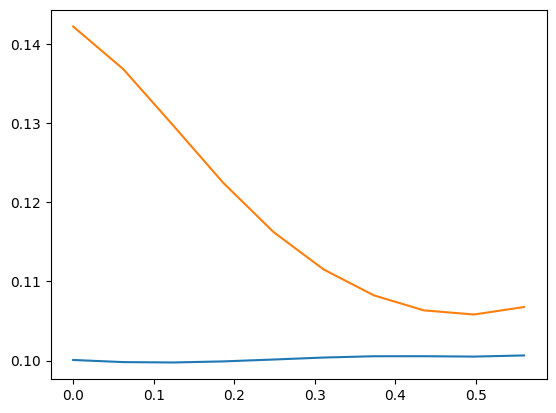

In [ ]:
# Plot single test



df_input = pd.read_csv("saved_models/dnn_6_(dpz)/df_te.csv")

zeile = 11


dV_ges    = df_input["dV_ges"][zeile]       # original units (as in CSV)
eps_0     = df_input["eps_0"][zeile] 
phi_0     = df_input["phi_0"][zeile] 
h_dis_0   = df_input["h_dis_0"][zeile] 
h_c_0     = df_input["h_c_0"][zeile] 
rho_c     = df_input["rho_c"][zeile] 
rho_d     = df_input["rho_d"][zeile] 
eta_c     = df_input["eta_c"][zeile] 
eta_d     = df_input["etc_d"][zeile] 
sigma     = df_input["sigma"][zeile] 
T         = df_input["T"][zeile] 
r_s_star  = df_input["r_S_star"][zeile]
h_p_star  = df_input["h_p_star"][zeile]
D_A       = df_input["D_A"][zeile]
L_A       = df_input["L_A"][zeile]
DPZ_pos    = np.fromstring(str(df_input['DPZ_pos_ivgu'][zeile]).strip("[]"), sep=",") / 100.0     # m
# ---- per-row NaN mask to keep only valid aligned entries ----
mask = ~(np.isnan(DPZ_pos))
DPZ_pos_v    = DPZ_pos[mask]
L_val = max(DPZ_pos_v)
print(L_val)
x_array   = np.linspace(0.0, L_val, 10)  # DPZ_pos

dV_ges_tr = dV_ges / 3.6 * 1e-6
const_feats = np.array(
    [dV_ges_tr, eps_0, phi_0, h_dis_0, h_c_0,
     rho_c, rho_d, eta_c, eta_d, sigma, T, r_s_star, h_p_star, D_A, L_A],
    dtype=np.float32
)
# Stack 10 rows, each with the 13 constant features + the varying DPZ_pos
X_real = np.hstack([
    np.repeat(const_feats[None, :], repeats=len(x_array), axis=0),
    x_array.reshape(-1, 1).astype(np.float32)
])  # shape (10, 14)
assert X_real.shape[1] == in_dim, f"Expected {in_dim} features, got {X_real.shape[1]}."
X_scaled = transform_minmax(X_real, x_mins, x_rng)
X_t = torch.from_numpy(X_scaled).to(device)
with torch.no_grad():
    Y_scaled = model(X_t).cpu().numpy()
def transform_minmax(X, mins, rng):
    rng_safe = np.where(rng > 0, rng, 1.0)
    return (X - mins) / rng_safe
def inverse_minmax(Ys, mins, rng):
    return Ys * rng + mins
Y_pred = inverse_minmax(Y_scaled, y_mins, y_rng)  

plt.plot(x_array, Y_pred[:, 1])
plt.plot(x_array, Y_pred[:,0]+Y_pred[:,1], label='DPZ_top')
plt.show()

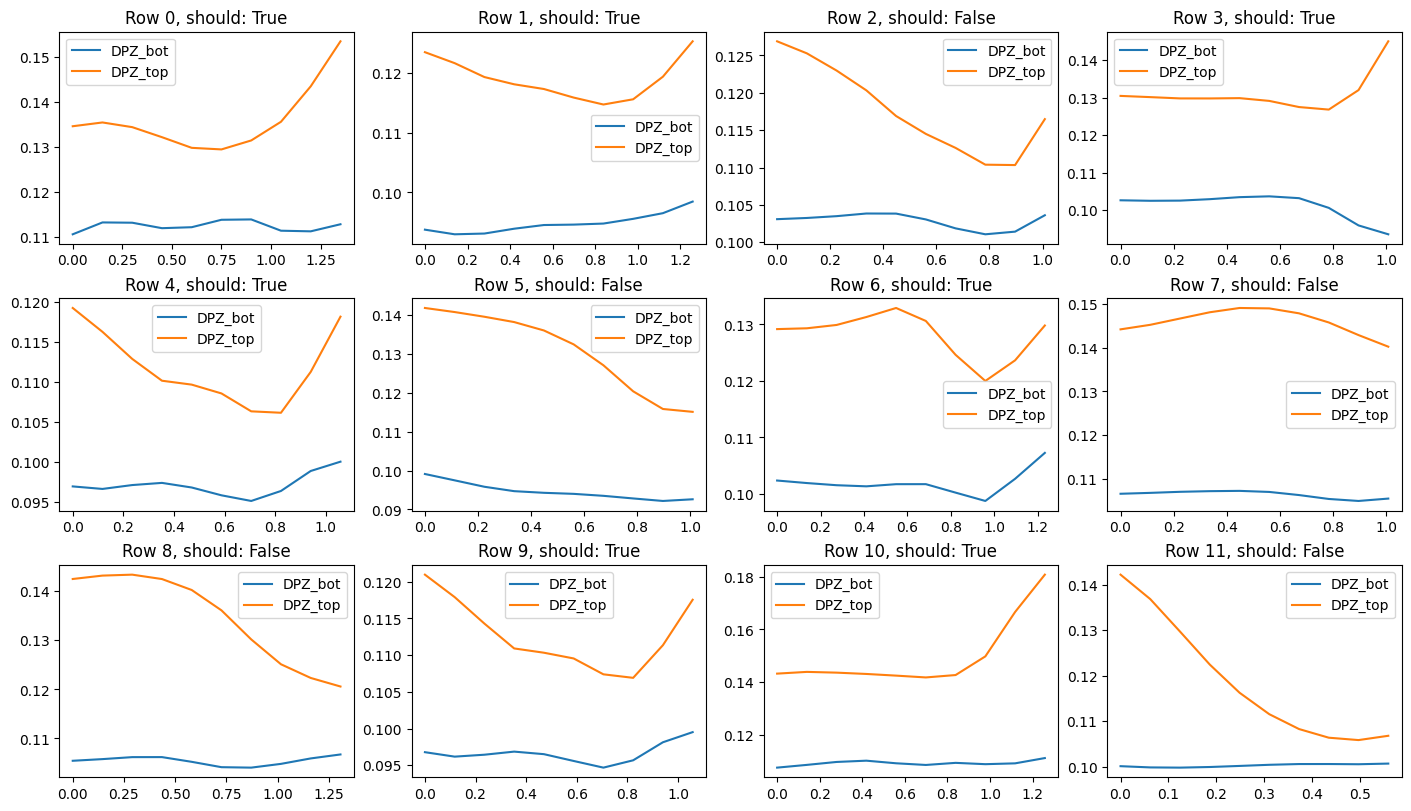

In [ ]:
# Plot multiple tests from test dataset


import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- helper functions ---
def transform_minmax(X, mins, rng):
    rng_safe = np.where(rng > 0, rng, 1.0)
    return (X - mins) / rng_safe

def inverse_minmax(Ys, mins, rng):
    return Ys * rng + mins

# --- load test dataframe ---
df_input = pd.read_csv("saved_models/dnn_6_(dpz)/df_te.csv")

# choose range of rows
idx_0, idx_end = 0, 11   # inclusive range [0..11] ##########################################################

n_rows = idx_end - idx_0 + 1
fig, axes = plt.subplots(3, 4, figsize=(14, 8), constrained_layout=True)
axes = axes.flatten()

if n_rows == 1:  # if only one subplot
    axes = [axes]

for k, zeile in enumerate(range(idx_0, idx_end+1)):
    ax = axes[k]

    dV_ges    = df_input["dV_ges"][zeile]       
    eps_0     = df_input["eps_0"][zeile] 
    phi_0     = df_input["phi_0"][zeile] 
    h_dis_0   = df_input["h_dis_0"][zeile] 
    h_c_0     = df_input["h_c_0"][zeile] 
    rho_c     = df_input["rho_c"][zeile] 
    rho_d     = df_input["rho_d"][zeile] 
    eta_c     = df_input["eta_c"][zeile] 
    eta_d     = df_input["etc_d"][zeile] 
    sigma     = df_input["sigma"][zeile] 
    T         = df_input["T"][zeile] 
    r_s_star  = df_input["r_S_star"][zeile]
    h_p_star  = df_input["h_p_star"][zeile]
    D_A       = df_input["D_A"][zeile]
    L_A       = df_input["L_A"][zeile]

    DPZ_pos = np.fromstring(str(df_input['DPZ_pos_ivgu'][zeile]).strip("[]"), sep=",") / 100.0
    mask = ~np.isnan(DPZ_pos)
    DPZ_pos_v = DPZ_pos[mask]
    L_val = max(DPZ_pos_v)
    x_array = np.linspace(0.0, L_val, 10)  # DPZ_pos

    dV_ges_tr = dV_ges / 3.6 * 1e-6
    const_feats = np.array(
        [dV_ges_tr, eps_0, phi_0, h_dis_0, h_c_0,
         rho_c, rho_d, eta_c, eta_d, sigma, T, r_s_star, h_p_star, D_A, L_A],
        dtype=np.float32
    )
    X_real = np.hstack([
        np.repeat(const_feats[None, :], repeats=len(x_array), axis=0),
        x_array.reshape(-1, 1).astype(np.float32)
    ])
    assert X_real.shape[1] == in_dim, f"Expected {in_dim} features, got {X_real.shape[1]}."
    X_scaled = transform_minmax(X_real, x_mins, x_rng)
    X_t = torch.from_numpy(X_scaled).to(device)

    with torch.no_grad():
        Y_scaled = model(X_t).cpu().numpy()
    Y_pred = inverse_minmax(Y_scaled, y_mins, y_rng)  

    ax.plot(x_array, Y_pred[:, 1], label='DPZ_bot')
    ax.plot(x_array, Y_pred[:, 0] + Y_pred[:, 1], label='DPZ_top')
    st = df_input["dpz_flooded"][zeile]
    ax.set_title(f"Row {zeile}, should: {st}")
    ax.legend()

plt.show()


In [ ]:
# Save all results to df_te under name "df_te_with_preds"

import numpy as np
import torch

def test_model(df_input):
    height_strs, bot_strs = [], []

    for i, row in df_input.iterrows():
        # --- read inputs for this row ---
        dV_ges    = row["dV_ges"]
        eps_0     = row["eps_0"]
        phi_0     = row["phi_0"]
        h_dis_0   = row["h_dis_0"]
        h_c_0     = row["h_c_0"]
        rho_c     = row["rho_c"]
        rho_d     = row["rho_d"]
        eta_c     = row["eta_c"]
        eta_d     = row["etc_d"]          # keep your column name as in CSV
        sigma     = row["sigma"]
        T         = row["T"]
        r_s_star  = row["r_S_star"]
        h_p_star  = row["h_p_star"]
        D_A       = row["D_A"]
        L_A       = row["L_A"]

        # DPZ positions (meters)
        DPZ_pos = np.fromstring(str(row["DPZ_pos_ivgu"]).strip("[]"), sep=",") / 100.0
        mask = ~np.isnan(DPZ_pos)
        if np.any(mask):
            L_val = DPZ_pos[mask].max()
        else:
            L_val = 0.0
        x_array = np.linspace(0.0, L_val, 10)

        # features
        dV_ges_tr = dV_ges / 3.6 * 1e-6
        const_feats = np.array(
            [dV_ges_tr, eps_0, phi_0, h_dis_0, h_c_0,
             rho_c, rho_d, eta_c, eta_d, sigma, T, r_s_star, h_p_star, D_A, L_A],
            dtype=np.float32
        )
        X_real = np.hstack([
            np.repeat(const_feats[None, :], repeats=len(x_array), axis=0),
            x_array.reshape(-1, 1).astype(np.float32)
        ])

        # scale, predict, inverse-scale
        assert X_real.shape[1] == in_dim, f"Expected {in_dim} features, got {X_real.shape[1]}."
        X_scaled = transform_minmax(X_real, x_mins, x_rng)
        X_t = torch.from_numpy(X_scaled).to(device)
        with torch.no_grad():
            Y_scaled = model(X_t).cpu().numpy()
        Y_pred = inverse_minmax(Y_scaled, y_mins, y_rng)  # shape (10, 2)

        # store in mm as stringified lists
        height_mm = (1000.0 * Y_pred[:, 0]).tolist()
        bot_mm    = (1000.0 * Y_pred[:, 1]).tolist()
        height_strs.append(str(height_mm))
        bot_strs.append(str(bot_mm))

    df_input = df_input.copy()
    df_input["DPZ_height_pred"] = height_strs  # strings of lists
    df_input["DPZ_bot_pred"]    = bot_strs     # strings of lists
    return df_input



###########################################################################################################################################
df_input = pd.read_csv("saved_models/dnn_6_(dpz)/df_te.csv")
df_out = test_model(df_input)
df_out.to_csv("saved_models/dnn_6_(dpz)/df_te_with_preds.csv", index=False)


In [4]:
# Save manual added results to df_te under name "df_te_results"
import pandas as pd
df_input = pd.read_csv("saved_models/dnn_6_(dpz)/df_te_with_preds.csv")
df_out = df_input.copy()
df_input_helper = pd.read_excel("saved_models/dnn_6_(dpz)/dnn_dpz_flooded_pred.xlsx")
df_out["dpz_flooded_pred"] = df_input_helper['dpz_flooded'].eq(1).values

df_out.to_csv('df_te_with_preds_and_dpz_flooded.csv', index=False)

In [3]:
# Save DPZ_pos_pred" to the final csv
import pandas as pd
import numpy as np
import torch

def test_model(df_input):
    height_strs, bot_strs, dpz_pos_str = [], [], []

    for i, row in df_input.iterrows():
        
        # DPZ positions (meters)
        DPZ_pos = np.fromstring(str(row["DPZ_pos_ivgu"]).strip("[]"), sep=",")
        mask = ~np.isnan(DPZ_pos)
        if np.any(mask):
            L_val = DPZ_pos[mask].max()
        else:
            L_val = 0.0
        x_array = np.linspace(0.0, L_val, 10)

        
        dpz_pos_cm = x_array.tolist()
        
        dpz_pos_str.append(str(dpz_pos_cm))
        

    df_input = df_input.copy()
    # df_input["DPZ_height_pred"] = height_strs  # strings of lists
    # df_input["DPZ_bot_pred"]    = bot_strs     # strings of lists
    df_input["DPZ_pos_pred"] = dpz_pos_str  # strings of lists
    return df_input



###########################################################################################################################################
df_input = pd.read_csv("saved_models/dnn_6_(dpz)/df_te_with_preds_and_dpz_flooded.csv")
df_out = test_model(df_input)
df_out.to_csv("saved_models/dnn_6_(dpz)/df_te_with_preds_and_dpz_flooded_and_dpz_pos.csv", index=False)


### 6.
Make optuna study for determining optimal hyper-parameters

In [ ]:
# tune_dnn_optuna.py
import os
import json
import math
from datetime import datetime

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import optuna
from optuna.pruners import MedianPruner
from optuna.trial import TrialState

# --------------------
# Config
# --------------------
DATA_BUNDLE_DIR = "saved_models/dnn_6_(dpz)"
DATA_TORCH_PATH = os.path.join(DATA_BUNDLE_DIR, "datasets_dnn_6_(dpz).pt")
MM_PARAMS_NPZ   = os.path.join(DATA_BUNDLE_DIR, "minmax_params_dnn_6_(dpz).npz")
RESULTS_DIR     = os.path.join(DATA_BUNDLE_DIR, "optuna_runs")

os.makedirs(RESULTS_DIR, exist_ok=True)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True  # faster on GPU

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose which split variant to use: "t" or "n"
SPLIT_VARIANT = "t"  # change to "n" if you want *_n

# --------------------
# Load data
# --------------------
if not os.path.exists(DATA_TORCH_PATH):
    raise FileNotFoundError(f"Could not find {DATA_TORCH_PATH}")

loaded_data = torch.load(DATA_TORCH_PATH)

X_train = loaded_data[f"X_train_{SPLIT_VARIANT}"].float()
Y_train = loaded_data[f"Y_train_{SPLIT_VARIANT}"].float()
X_val   = loaded_data[f"X_val_{SPLIT_VARIANT}"].float()
Y_val   = loaded_data[f"Y_val_{SPLIT_VARIANT}"].float()
X_test  = loaded_data[f"X_test_{SPLIT_VARIANT}"].float()
Y_test  = loaded_data[f"Y_test_{SPLIT_VARIANT}"].float()

mm = np.load(MM_PARAMS_NPZ)
y_mins = torch.tensor(mm["y_mins"], dtype=torch.float32)
y_rng  = torch.tensor(mm["y_rng"],  dtype=torch.float32)

in_dim  = X_train.shape[1]
out_dim = Y_train.shape[1]

# --------------------
# Model definition (copied from your DNN with same init)
# --------------------
class DNN(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, activation="silu", dropout=0.0):
        super().__init__()
        acts = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "silu": nn.SiLU,
            "tanh": nn.Tanh
        }
        if activation not in acts:
            raise ValueError(f"activation must be one of {list(acts.keys())}")
        Act = acts[activation]

        layers = []
        prev = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), Act()]
            if dropout and dropout > 0:
                layers += [nn.Dropout(p=dropout)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

        for m in self.net:
            if isinstance(m, nn.Linear):
                if activation in ("relu", "silu", "gelu"):
                    nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                else:
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        return self.net(x)

# --------------------
# Helpers
# --------------------
def denorm_y(y_norm: torch.Tensor) -> torch.Tensor:
    # y = y_norm * y_rng + y_mins (broadcast over batch)
    return y_norm * y_rng.to(y_norm.device) + y_mins.to(y_norm.device)

@torch.no_grad()
def mse_original_scale(model: nn.Module, loader: DataLoader, device=DEVICE) -> float:
    model.eval()
    se_sum, n_obs = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)
        pred_den = denorm_y(pred)
        y_den    = denorm_y(yb)
        se_sum += torch.sum((pred_den - y_den) ** 2).item()
        n_obs  += yb.numel()
    mse = se_sum / n_obs
    return float(mse)

def make_hidden_dims(trial: optuna.Trial) -> list:
    n_layers = trial.suggest_int("n_layers", 1, 4)
    dims = []
    for i in range(n_layers):
        dims.append(trial.suggest_categorical(f"width_l{i+1}", [64, 96, 128, 192, 256, 384, 512]))
    return dims

def make_optimizer(opt_name: str, params, lr: float, wd: float):
    if opt_name == "adam":
        return torch.optim.Adam(params, lr=lr, weight_decay=wd)
    elif opt_name == "adamw":
        return torch.optim.AdamW(params, lr=lr, weight_decay=wd)
    else:
        raise ValueError(opt_name)

# --------------------
# Objective
# --------------------
def objective(trial: optuna.Trial) -> float:
    # Search space
    hidden_dims = make_hidden_dims(trial)
    activation  = trial.suggest_categorical("activation", ["relu", "gelu", "silu", "tanh"])
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)
    lr          = trial.suggest_float("lr", 1e-5, 3e-3, log=True)
    weight_decay= trial.suggest_float("weight_decay", 1e-8, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
    optimizer_n = trial.suggest_categorical("optimizer", ["adam", "adamw"])
    max_epochs  = trial.suggest_int("max_epochs", 80, 250)

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(TensorDataset(X_val,   Y_val),   batch_size=batch_size, shuffle=False, drop_last=False)

    # Model / opt / loss
    model = DNN(in_dim, hidden_dims, out_dim, activation=activation, dropout=dropout).to(DEVICE)
    opt   = make_optimizer(optimizer_n, model.parameters(), lr, weight_decay)
    loss_fn = nn.MSELoss()

    # OneCycleLR (optional): only if epochs >= 50
    use_scheduler = max_epochs >= 50
    if use_scheduler:
        # steps_per_epoch = max(1, len(train_loader))
        # scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, epochs=max_epochs, steps_per_epoch=steps_per_epoch)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.1, patience=30)
    else:
        scheduler = None

    # Early stopping + pruning
    best_val = float("inf")
    best_state = None
    patience = 30
    patience_left = patience

    for epoch in range(1, max_epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            

        # Validation metric (original scale MSE)
        val_mse = mse_original_scale(model, val_loader, device=DEVICE)
        if scheduler:
            scheduler.step(val_mse)

        # Report to Optuna and check pruning
        trial.report(val_mse, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stopping tracking
        if val_mse < best_val - 1e-6:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break

    # Optionally save the trial's best model
    trial_dir = os.path.join(RESULTS_DIR, f"trial_{trial.number:04d}")
    os.makedirs(trial_dir, exist_ok=True)
    with open(os.path.join(trial_dir, "params.json"), "w") as f:
        json.dump(trial.params, f, indent=2)
    if best_state is not None:
        torch.save(best_state, os.path.join(trial_dir, "best_state.pt"))

    return best_val

# --------------------
# Run Study
# --------------------
def main():
    study_name = f"dnn_optuna_{SPLIT_VARIANT}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    storage = None  # e.g., "sqlite:///optuna_dnn.db" if you want persistence
    study = optuna.create_study(
        study_name=study_name,
        direction="minimize",
        storage=storage,
        load_if_exists=False,
        pruner=MedianPruner(n_warmup_steps=15),
        sampler=optuna.samplers.TPESampler(seed=SEED, n_startup_trials=15, multivariate=True, group=True),
    )

    # You can adjust n_trials as you like
    study.optimize(objective, n_trials=60, show_progress_bar=True, gc_after_trial=True)

    print("\nStudy statistics:")
    print(f"  Completed trials: {len(study.trials)}")
    pruned_trials = [t for t in study.trials if t.state == TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
    print(f"  Pruned trials: {len(pruned_trials)}")
    print(f"  Successful trials: {len(complete_trials)}")

    print("\nBest trial:")
    best = study.best_trial
    print(f"  Value (Val MSE, original scale): {best.value:.6f}")
    print("  Params:")
    for k, v in best.params.items():
        print(f"    {k}: {v}")

    # Save best params + optionally evaluate on test set using saved state
    best_dir = os.path.join(RESULTS_DIR, "best")
    os.makedirs(best_dir, exist_ok=True)
    with open(os.path.join(best_dir, "best_params.json"), "w") as f:
        json.dump(best.params, f, indent=2)

    # Rebuild best model and evaluate on test
    hidden_dims = [best.params[f"width_l{i+1}"] for i in range(best.params["n_layers"])]
    model = DNN(in_dim, hidden_dims, out_dim,
                activation=best.params["activation"],
                dropout=best.params["dropout"]).to(DEVICE)

    # Load the saved state from the best trial directory if present; otherwise use current weights
    best_trial_dir = os.path.join(RESULTS_DIR, f"trial_{best.number:04d}")
    state_path = os.path.join(best_trial_dir, "best_state.pt")
    if os.path.exists(state_path):
        model.load_state_dict(torch.load(state_path, map_location=DEVICE))

    test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=4096, shuffle=False)
    test_mse = mse_original_scale(model, test_loader, device=DEVICE)
    print(f"\nTest MSE (original scale): {test_mse:.6f}")
    with open(os.path.join(best_dir, "best_summary.json"), "w") as f:
        json.dump({"val_mse": best.value, "test_mse": test_mse, "trial_number": best.number}, f, indent=2)

    # Save final best model weights
    torch.save(model.state_dict(), os.path.join(best_dir, "best_model_state.pt"))

if __name__ == "__main__":
    main()


c:\Users\iagr9\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\iagr9\AppData\Local\Temp\ipykernel_193468\1856539851.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

[I 2025-08-26 12:04:46,513] Trial 0 finished with value: 4.9596284952713177e-05 and parameters: {'n_layers': 2, 'width_l1': 64, 'width_l2': 192, 'activation': 'silu', 'dropout': 0.14561457009902096, 'lr': 0.0003278187653397617, 'weight_decay': 6.870101665590006e-08, 'batch_size': 512, 'optimizer': 'adamw', 'max_epochs': 181}. Best is trial 0 with value: 4.9596284952713177e-05.


Best trial: 0. Best value: 4.95963e-05:   2%|▏         | 1/60 [01:09<26:12, 26.65s/it]

[I 2025-08-26 12:05:29,397] Trial 1 finished with value: 5.798325976987447e-05 and parameters: {'n_layers': 1, 'width_l1': 256, 'activation': 'gelu', 'dropout': 0.2475884550556351, 'lr': 1.216702881459345e-05, 'weight_decay': 0.0028570800750407216, 'batch_size': 128, 'optimizer': 'adam', 'max_epochs': 245}. Best is trial 0 with value: 4.9596284952713177e-05.


Best trial: 0. Best value: 4.95963e-05:   3%|▎         | 2/60 [02:24<35:04, 36.29s/it]

[I 2025-08-26 12:06:44,542] Trial 2 finished with value: 1.8507928795467404e-05 and parameters: {'n_layers': 4, 'width_l1': 64, 'width_l2': 192, 'width_l3': 192, 'width_l4': 64, 'activation': 'relu', 'dropout': 0.1554911608578311, 'lr': 6.390259853593123e-05, 'weight_decay': 0.00023858166771428845, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 175}. Best is trial 2 with value: 1.8507928795467404e-05.


Best trial: 2. Best value: 1.85079e-05:   5%|▌         | 3/60 [04:51<51:42, 54.43s/it]

[I 2025-08-26 12:09:11,197] Trial 3 finished with value: 5.2519511352026406e-05 and parameters: {'n_layers': 4, 'width_l1': 512, 'width_l2': 128, 'width_l3': 192, 'width_l4': 384, 'activation': 'tanh', 'dropout': 0.4303652916281717, 'lr': 1.0404501336028154e-05, 'weight_decay': 1.160068983900714e-05, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 168}. Best is trial 2 with value: 1.8507928795467404e-05.


Best trial: 2. Best value: 1.85079e-05:   8%|▊         | 5/60 [05:33<1:06:42, 72.77s/it]

[I 2025-08-26 12:09:53,170] Trial 4 finished with value: 6.68294342176523e-05 and parameters: {'n_layers': 3, 'width_l1': 96, 'width_l2': 384, 'width_l3': 128, 'activation': 'relu', 'dropout': 0.26788734203737924, 'lr': 1.673627134612419e-05, 'weight_decay': 0.0010275784161907387, 'batch_size': 512, 'optimizer': 'adam', 'max_epochs': 167}. Best is trial 2 with value: 1.8507928795467404e-05.


Best trial: 2. Best value: 1.85079e-05:  10%|█         | 6/60 [05:58<51:04, 56.75s/it]  

[I 2025-08-26 12:10:18,838] Trial 5 finished with value: 4.166601380954186e-05 and parameters: {'n_layers': 1, 'width_l1': 256, 'activation': 'gelu', 'dropout': 0.3299920230170895, 'lr': 0.0010576902036995882, 'weight_decay': 2.14390170468164e-05, 'batch_size': 512, 'optimizer': 'adam', 'max_epochs': 137}. Best is trial 2 with value: 1.8507928795467404e-05.


Best trial: 2. Best value: 1.85079e-05:  10%|█         | 6/60 [06:02<51:04, 56.75s/it]

[I 2025-08-26 12:10:22,623] Trial 6 pruned. 


Best trial: 2. Best value: 1.85079e-05:  13%|█▎        | 8/60 [06:07<24:36, 28.40s/it]

[I 2025-08-26 12:10:27,415] Trial 7 pruned. 


Best trial: 2. Best value: 1.85079e-05:  15%|█▌        | 9/60 [06:17<19:17, 22.70s/it]

[I 2025-08-26 12:10:37,589] Trial 8 finished with value: 5.0976740567421075e-05 and parameters: {'n_layers': 2, 'width_l1': 128, 'width_l2': 64, 'activation': 'tanh', 'dropout': 0.43353615929005185, 'lr': 0.0018289742175371328, 'weight_decay': 1.1696458740181163e-05, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 137}. Best is trial 2 with value: 1.8507928795467404e-05.


Best trial: 2. Best value: 1.85079e-05:  15%|█▌        | 9/60 [07:03<19:17, 22.70s/it]

[I 2025-08-26 12:11:23,372] Trial 9 finished with value: 3.5003918886407824e-05 and parameters: {'n_layers': 2, 'width_l1': 512, 'width_l2': 128, 'activation': 'gelu', 'dropout': 0.265677315784074, 'lr': 0.00021838296130342758, 'weight_decay': 6.676969754945983e-05, 'batch_size': 128, 'optimizer': 'adam', 'max_epochs': 155}. Best is trial 2 with value: 1.8507928795467404e-05.


Best trial: 2. Best value: 1.85079e-05:  17%|█▋        | 10/60 [07:25<25:02, 30.06s/it]

[I 2025-08-26 12:11:45,345] Trial 10 finished with value: 3.21557325454099e-05 and parameters: {'n_layers': 1, 'width_l1': 96, 'activation': 'silu', 'dropout': 0.13996694847297142, 'lr': 0.002319087217474401, 'weight_decay': 0.0002675355506980832, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 82}. Best is trial 2 with value: 1.8507928795467404e-05.


Best trial: 2. Best value: 1.85079e-05:  20%|██        | 12/60 [07:29<16:08, 20.17s/it]

[I 2025-08-26 12:11:49,183] Trial 11 pruned. 


Best trial: 2. Best value: 1.85079e-05:  20%|██        | 12/60 [09:00<16:08, 20.17s/it]

[I 2025-08-26 12:13:20,129] Trial 12 pruned. 


Best trial: 2. Best value: 1.85079e-05:  22%|██▏       | 13/60 [10:09<32:55, 42.02s/it]

[I 2025-08-26 12:14:29,592] Trial 13 finished with value: 1.3405087959957504e-05 and parameters: {'n_layers': 2, 'width_l1': 192, 'width_l2': 128, 'activation': 'silu', 'dropout': 0.15965681879520743, 'lr': 0.0022564135127852, 'weight_decay': 0.005054088956519247, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 208}. Best is trial 13 with value: 1.3405087959957504e-05.


Best trial: 13. Best value: 1.34051e-05:  25%|██▌       | 15/60 [10:23<29:12, 38.95s/it]

[I 2025-08-26 12:14:43,435] Trial 14 pruned. 


Best trial: 13. Best value: 1.34051e-05:  25%|██▌       | 15/60 [12:12<29:12, 38.95s/it]

[I 2025-08-26 12:16:32,180] Trial 15 finished with value: 1.2958173158494901e-05 and parameters: {'n_layers': 4, 'width_l1': 64, 'width_l2': 512, 'width_l3': 192, 'width_l4': 64, 'activation': 'relu', 'dropout': 0.12204463202991442, 'lr': 0.00016867308274551797, 'weight_decay': 0.00013353799117876255, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 218}. Best is trial 15 with value: 1.2958173158494901e-05.


Best trial: 15. Best value: 1.29582e-05:  27%|██▋       | 16/60 [12:53<44:15, 60.35s/it]

[I 2025-08-26 12:17:13,436] Trial 16 finished with value: 2.6540262827741874e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'silu', 'dropout': 0.11004776477043404, 'lr': 0.0022050847026703593, 'weight_decay': 0.000676792787080488, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 244}. Best is trial 15 with value: 1.2958173158494901e-05.


Best trial: 15. Best value: 1.29582e-05:  28%|██▊       | 17/60 [15:20<38:56, 54.34s/it]

[I 2025-08-26 12:19:40,316] Trial 17 finished with value: 9.172139679473426e-06 and parameters: {'n_layers': 4, 'width_l1': 64, 'width_l2': 512, 'width_l3': 384, 'width_l4': 64, 'activation': 'gelu', 'dropout': 0.03205343693328462, 'lr': 0.0005253675762663736, 'weight_decay': 1.1573583496499484e-06, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 240}. Best is trial 17 with value: 9.172139679473426e-06.


Best trial: 17. Best value: 9.17214e-06:  30%|███       | 18/60 [17:36<57:57, 82.80s/it]

[I 2025-08-26 12:21:56,843] Trial 18 finished with value: 9.269019396166792e-06 and parameters: {'n_layers': 4, 'width_l1': 64, 'width_l2': 512, 'width_l3': 384, 'width_l4': 64, 'activation': 'gelu', 'dropout': 0.11063610036379316, 'lr': 0.0008616375744486008, 'weight_decay': 5.358955605552678e-07, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 221}. Best is trial 17 with value: 9.172139679473426e-06.


Best trial: 17. Best value: 9.17214e-06:  33%|███▎      | 20/60 [19:18<1:05:54, 98.87s/it]

[I 2025-08-26 12:23:38,364] Trial 19 finished with value: 1.1407866926068285e-05 and parameters: {'n_layers': 3, 'width_l1': 64, 'width_l2': 512, 'width_l3': 384, 'activation': 'gelu', 'dropout': 0.10078317500823947, 'lr': 0.00148432744590687, 'weight_decay': 1.4879364435731448e-06, 'batch_size': 256, 'optimizer': 'adamw', 'max_epochs': 228}. Best is trial 17 with value: 9.172139679473426e-06.


Best trial: 17. Best value: 9.17214e-06:  35%|███▌      | 21/60 [19:30<47:17, 72.76s/it]  

[I 2025-08-26 12:23:50,241] Trial 20 pruned. 


Best trial: 17. Best value: 9.17214e-06:  37%|███▋      | 22/60 [20:41<45:50, 72.39s/it]

[I 2025-08-26 12:25:01,773] Trial 21 pruned. 


Best trial: 17. Best value: 9.17214e-06:  37%|███▋      | 22/60 [22:14<45:50, 72.39s/it]

[I 2025-08-26 12:26:34,485] Trial 22 finished with value: 1.0818123882927466e-05 and parameters: {'n_layers': 3, 'width_l1': 512, 'width_l2': 512, 'width_l3': 384, 'activation': 'gelu', 'dropout': 0.11317700827399277, 'lr': 0.0028370208955534977, 'weight_decay': 3.532690363448715e-07, 'batch_size': 128, 'optimizer': 'adam', 'max_epochs': 243}. Best is trial 17 with value: 9.172139679473426e-06.


Best trial: 17. Best value: 9.17214e-06:  38%|███▊      | 23/60 [22:23<48:54, 79.31s/it]

[I 2025-08-26 12:26:43,405] Trial 23 pruned. 


Best trial: 17. Best value: 9.17214e-06:  42%|████▏     | 25/60 [22:29<24:32, 42.06s/it]

[I 2025-08-26 12:26:49,782] Trial 24 pruned. 


Best trial: 17. Best value: 9.17214e-06:  43%|████▎     | 26/60 [22:38<18:09, 32.05s/it]

[I 2025-08-26 12:26:58,475] Trial 25 pruned. 


Best trial: 17. Best value: 9.17214e-06:  43%|████▎     | 26/60 [24:14<18:09, 32.05s/it]

[I 2025-08-26 12:28:34,532] Trial 26 finished with value: 1.105876971981464e-05 and parameters: {'n_layers': 3, 'width_l1': 512, 'width_l2': 512, 'width_l3': 384, 'activation': 'gelu', 'dropout': 0.021933802875545166, 'lr': 0.002502144137409699, 'weight_decay': 1.8021225589544238e-06, 'batch_size': 128, 'optimizer': 'adam', 'max_epochs': 217}. Best is trial 17 with value: 9.172139679473426e-06.


Best trial: 17. Best value: 9.17214e-06:  45%|████▌     | 27/60 [26:02<28:25, 51.69s/it]

[I 2025-08-26 12:30:22,638] Trial 27 finished with value: 1.1056947111380092e-05 and parameters: {'n_layers': 4, 'width_l1': 384, 'width_l2': 512, 'width_l3': 384, 'width_l4': 512, 'activation': 'gelu', 'dropout': 0.11535015368006842, 'lr': 0.0016422882567663367, 'weight_decay': 5.522890269918851e-08, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 222}. Best is trial 17 with value: 9.172139679473426e-06.


Best trial: 17. Best value: 9.17214e-06:  47%|████▋     | 28/60 [27:18<36:32, 68.52s/it]

[I 2025-08-26 12:31:38,323] Trial 28 finished with value: 1.800160142314174e-05 and parameters: {'n_layers': 4, 'width_l1': 64, 'width_l2': 256, 'width_l3': 384, 'width_l4': 128, 'activation': 'gelu', 'dropout': 0.26182238754160464, 'lr': 0.0019233016310677491, 'weight_decay': 3.823486425101486e-06, 'batch_size': 128, 'optimizer': 'adam', 'max_epochs': 231}. Best is trial 17 with value: 9.172139679473426e-06.


Best trial: 17. Best value: 9.17214e-06:  48%|████▊     | 29/60 [30:06<36:47, 71.21s/it]

[I 2025-08-26 12:34:26,771] Trial 29 finished with value: 7.896163339182749e-06 and parameters: {'n_layers': 4, 'width_l1': 192, 'width_l2': 384, 'width_l3': 384, 'width_l4': 192, 'activation': 'gelu', 'dropout': 0.05701754588446239, 'lr': 0.0008784326862261809, 'weight_decay': 1.5528418818105578e-07, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 231}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  50%|█████     | 30/60 [32:38<50:15, 100.51s/it]

[I 2025-08-26 12:36:58,335] Trial 30 finished with value: 1.159566798492051e-05 and parameters: {'n_layers': 4, 'width_l1': 192, 'width_l2': 384, 'width_l3': 96, 'width_l4': 192, 'activation': 'gelu', 'dropout': 0.09074245158983894, 'lr': 0.00025802594958282095, 'weight_decay': 1.170060329220176e-08, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 250}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  52%|█████▏    | 31/60 [35:00<55:52, 115.60s/it]

[I 2025-08-26 12:39:20,029] Trial 31 finished with value: 1.2430517889091183e-05 and parameters: {'n_layers': 4, 'width_l1': 192, 'width_l2': 384, 'width_l3': 384, 'width_l4': 192, 'activation': 'gelu', 'dropout': 0.04603439201019565, 'lr': 0.0014712441559502614, 'weight_decay': 8.078272530569277e-06, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 183}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  55%|█████▌    | 33/60 [35:09<39:47, 88.42s/it] 

[I 2025-08-26 12:39:28,906] Trial 32 pruned. 


Best trial: 29. Best value: 7.89616e-06:  55%|█████▌    | 33/60 [36:03<39:47, 88.42s/it]

[I 2025-08-26 12:40:23,219] Trial 33 finished with value: 1.1056515139292363e-05 and parameters: {'n_layers': 3, 'width_l1': 256, 'width_l2': 384, 'width_l3': 384, 'activation': 'relu', 'dropout': 0.05612754923605755, 'lr': 0.00020134318123243722, 'weight_decay': 9.467578108507623e-08, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 197}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  58%|█████▊    | 35/60 [36:13<24:01, 57.68s/it]

[I 2025-08-26 12:40:33,153] Trial 34 pruned. 


Best trial: 29. Best value: 7.89616e-06:  58%|█████▊    | 35/60 [37:01<24:01, 57.68s/it]

[I 2025-08-26 12:41:21,792] Trial 35 finished with value: 1.0052871336559596e-05 and parameters: {'n_layers': 4, 'width_l1': 128, 'width_l2': 512, 'width_l3': 128, 'width_l4': 192, 'activation': 'relu', 'dropout': 0.072069224468266, 'lr': 0.001678055215347024, 'weight_decay': 2.5432552939398392e-08, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 240}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  60%|██████    | 36/60 [38:08<21:59, 55.00s/it]

[I 2025-08-26 12:42:28,208] Trial 36 finished with value: 9.845915779275552e-06 and parameters: {'n_layers': 4, 'width_l1': 128, 'width_l2': 384, 'width_l3': 128, 'width_l4': 192, 'activation': 'relu', 'dropout': 0.06655588275291033, 'lr': 0.0013015480279773635, 'weight_decay': 1.3703531629586888e-08, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 236}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  62%|██████▏   | 37/60 [39:27<22:26, 58.56s/it]

[I 2025-08-26 12:43:47,173] Trial 37 finished with value: 9.374481038548765e-06 and parameters: {'n_layers': 4, 'width_l1': 128, 'width_l2': 384, 'width_l3': 128, 'width_l4': 192, 'activation': 'relu', 'dropout': 0.12763659144733552, 'lr': 0.0008324579131012989, 'weight_decay': 5.979260753149234e-08, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 168}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  63%|██████▎   | 38/60 [40:13<23:53, 65.15s/it]

[I 2025-08-26 12:44:33,150] Trial 38 finished with value: 1.1256261198392773e-05 and parameters: {'n_layers': 4, 'width_l1': 128, 'width_l2': 384, 'width_l3': 128, 'width_l4': 64, 'activation': 'relu', 'dropout': 0.17165863573023127, 'lr': 0.0008891977032133198, 'weight_decay': 1.215669066086535e-06, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 119}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  65%|██████▌   | 39/60 [41:17<20:39, 59.02s/it]

[I 2025-08-26 12:45:37,379] Trial 39 finished with value: 1.2959179552278025e-05 and parameters: {'n_layers': 4, 'width_l1': 512, 'width_l2': 384, 'width_l3': 64, 'width_l4': 192, 'activation': 'relu', 'dropout': 0.22780700395202952, 'lr': 0.0018463150887026568, 'weight_decay': 1.3033054812162712e-08, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 165}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  67%|██████▋   | 40/60 [42:13<20:18, 60.90s/it]

[I 2025-08-26 12:46:33,833] Trial 40 finished with value: 1.0439175904745449e-05 and parameters: {'n_layers': 3, 'width_l1': 64, 'width_l2': 384, 'width_l3': 128, 'activation': 'relu', 'dropout': 0.053711721919814576, 'lr': 0.0003489655872537012, 'weight_decay': 1.1168089697148238e-07, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 160}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  68%|██████▊   | 41/60 [43:40<18:54, 59.70s/it]

[I 2025-08-26 12:48:00,342] Trial 41 finished with value: 1.1568696815326499e-05 and parameters: {'n_layers': 4, 'width_l1': 128, 'width_l2': 384, 'width_l3': 128, 'width_l4': 192, 'activation': 'silu', 'dropout': 0.13539437181910835, 'lr': 0.0010442382218196458, 'weight_decay': 1.3616948565452096e-08, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 197}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  72%|███████▏  | 43/60 [44:20<16:40, 58.83s/it]

[I 2025-08-26 12:48:40,308] Trial 42 finished with value: 1.0550485891750819e-05 and parameters: {'n_layers': 4, 'width_l1': 96, 'width_l2': 384, 'width_l3': 128, 'width_l4': 192, 'activation': 'relu', 'dropout': 0.10852389312172447, 'lr': 0.0014424504860430553, 'weight_decay': 2.369042805360499e-08, 'batch_size': 256, 'optimizer': 'adamw', 'max_epochs': 218}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  73%|███████▎  | 44/60 [44:24<11:17, 42.35s/it]

[I 2025-08-26 12:48:44,216] Trial 43 pruned. 


Best trial: 29. Best value: 7.89616e-06:  75%|███████▌  | 45/60 [44:38<08:30, 34.00s/it]

[I 2025-08-26 12:48:58,715] Trial 44 pruned. 


Best trial: 29. Best value: 7.89616e-06:  75%|███████▌  | 45/60 [45:42<08:30, 34.00s/it]

[I 2025-08-26 12:50:02,562] Trial 45 finished with value: 9.824773826494493e-06 and parameters: {'n_layers': 3, 'width_l1': 128, 'width_l2': 384, 'width_l3': 128, 'activation': 'relu', 'dropout': 0.093803564866946, 'lr': 0.0004132775071430166, 'weight_decay': 1.2770005437638155e-07, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 243}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  78%|███████▊  | 47/60 [45:50<07:01, 32.44s/it]

[I 2025-08-26 12:50:10,812] Trial 46 pruned. 


Best trial: 29. Best value: 7.89616e-06:  80%|████████  | 48/60 [45:59<05:04, 25.38s/it]

[I 2025-08-26 12:50:19,736] Trial 47 pruned. 


Best trial: 29. Best value: 7.89616e-06:  82%|████████▏ | 49/60 [46:07<03:39, 19.94s/it]

[I 2025-08-26 12:50:26,982] Trial 48 pruned. 


Best trial: 29. Best value: 7.89616e-06:  83%|████████▎ | 50/60 [46:11<02:31, 15.18s/it]

[I 2025-08-26 12:50:31,065] Trial 49 pruned. 


Best trial: 29. Best value: 7.89616e-06:  83%|████████▎ | 50/60 [47:34<02:31, 15.18s/it]

[I 2025-08-26 12:51:54,953] Trial 50 finished with value: 1.1357683339004629e-05 and parameters: {'n_layers': 4, 'width_l1': 128, 'width_l2': 192, 'width_l3': 192, 'width_l4': 256, 'activation': 'gelu', 'dropout': 0.20858289207287867, 'lr': 0.0019043837846684022, 'weight_decay': 9.755634003024516e-06, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 210}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  85%|████████▌ | 51/60 [48:56<05:22, 35.84s/it]

[I 2025-08-26 12:53:16,277] Trial 51 finished with value: 8.394413517483676e-06 and parameters: {'n_layers': 3, 'width_l1': 192, 'width_l2': 384, 'width_l3': 128, 'activation': 'relu', 'dropout': 0.10522290995250624, 'lr': 0.0007797789445471774, 'weight_decay': 3.082251480467117e-07, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 249}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  88%|████████▊ | 53/60 [49:04<04:18, 36.87s/it]

[I 2025-08-26 12:53:24,277] Trial 52 pruned. 


Best trial: 29. Best value: 7.89616e-06:  88%|████████▊ | 53/60 [50:44<04:18, 36.87s/it]

[I 2025-08-26 12:55:04,478] Trial 53 finished with value: 1.0320053628258089e-05 and parameters: {'n_layers': 3, 'width_l1': 512, 'width_l2': 384, 'width_l3': 128, 'activation': 'relu', 'dropout': 0.12764419382117642, 'lr': 0.00016146703820854642, 'weight_decay': 1.0691853221226533e-06, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 233}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  90%|█████████ | 54/60 [52:07<05:37, 56.29s/it]

[I 2025-08-26 12:56:27,411] Trial 54 finished with value: 9.954242064698823e-06 and parameters: {'n_layers': 3, 'width_l1': 192, 'width_l2': 384, 'width_l3': 512, 'activation': 'relu', 'dropout': 0.20819882293952527, 'lr': 0.0016960807227834978, 'weight_decay': 8.594166481903275e-07, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 249}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  93%|█████████▎| 56/60 [52:13<03:05, 46.33s/it]

[I 2025-08-26 12:56:33,562] Trial 55 pruned. 


Best trial: 29. Best value: 7.89616e-06:  93%|█████████▎| 56/60 [52:24<03:05, 46.33s/it]

[I 2025-08-26 12:56:44,744] Trial 56 pruned. 


Best trial: 29. Best value: 7.89616e-06:  97%|█████████▋| 58/60 [52:32<00:54, 27.36s/it]

[I 2025-08-26 12:56:52,508] Trial 57 pruned. 


Best trial: 29. Best value: 7.89616e-06:  98%|█████████▊| 59/60 [53:26<00:35, 35.41s/it]

[I 2025-08-26 12:57:46,685] Trial 58 finished with value: 9.879263870971045e-06 and parameters: {'n_layers': 4, 'width_l1': 128, 'width_l2': 512, 'width_l3': 96, 'width_l4': 96, 'activation': 'relu', 'dropout': 0.21401259419722996, 'lr': 0.0013257440494361169, 'weight_decay': 3.808548824650013e-08, 'batch_size': 256, 'optimizer': 'adam', 'max_epochs': 150}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06:  98%|█████████▊| 59/60 [54:37<00:35, 35.41s/it]

[I 2025-08-26 12:58:57,153] Trial 59 finished with value: 1.1082588419715952e-05 and parameters: {'n_layers': 4, 'width_l1': 96, 'width_l2': 384, 'width_l3': 384, 'width_l4': 64, 'activation': 'gelu', 'dropout': 0.004314415631951139, 'lr': 0.0021428961760157645, 'weight_decay': 6.889499248090745e-08, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 224}. Best is trial 29 with value: 7.896163339182749e-06.


Best trial: 29. Best value: 7.89616e-06: 100%|██████████| 60/60 [54:39<00:00, 54.66s/it]
C:\Users\iagr9\AppData\Local\Temp\ipykernel_193468\1856539851.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related 


Study statistics:
  Completed trials: 60
  Pruned trials: 22
  Successful trials: 38

Best trial:
  Value (Val MSE, original scale): 0.000008
  Params:
    n_layers: 4
    width_l1: 192
    width_l2: 384
    width_l3: 384
    width_l4: 192
    activation: gelu
    dropout: 0.05701754588446239
    lr: 0.0008784326862261809
    weight_decay: 1.5528418818105578e-07
    batch_size: 64
    optimizer: adam
    max_epochs: 231

Test MSE (original scale): 0.000023
